In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape, GRU
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting
from keras.regularizers import l2

(2115, 22, 1000)
(2115, 22, 1000)
(2115, 1000)


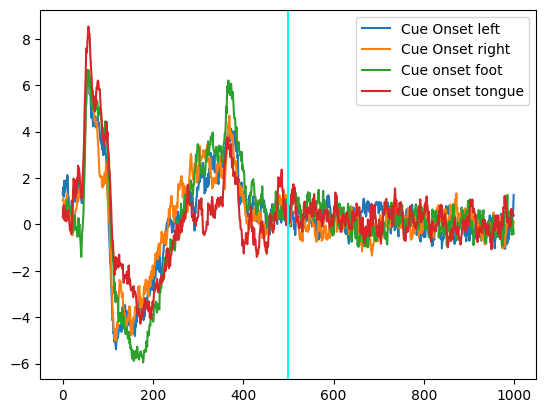

In [2]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
print(X_train_valid.shape)
ch_data = X_train_valid[:,8,:]
print(ch_data.shape)
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    # print('Shape of Y:',total_y.shape)
    return total_X,total_y



def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 1), axis=3)
    
    
    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
def hybrid(size):
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(size,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(GRU(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    return hybrid_cnn_lstm_model

In [5]:
X_test_prep = test_data_prep(X_test) 
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_train,y_train = train_data_prep(x_train_split,y_train_split,1,1,True)
x_valid,y_valid = train_data_prep(x_valid_split,y_valid_split,1,1,True)
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 150

100
Epoch 1/150
88/88 [==============================] - 4s 28ms/step - loss: 1.3916 - accuracy: 0.2540 - val_loss: 1.3903 - val_accuracy: 0.2640
Epoch 2/150
88/88 [==============================] - 2s 27ms/step - loss: 1.3760 - accuracy: 0.2926 - val_loss: 1.3868 - val_accuracy: 0.2827
Epoch 3/150
88/88 [==============================] - 2s 28ms/step - loss: 1.3631 - accuracy: 0.3189 - val_loss: 1.3531 - val_accuracy: 0.3507
Epoch 4/150
88/88 [==============================] - 2s 27ms/step - loss: 1.3518 - accuracy: 0.3324 - val_loss: 1.3354 - val_accuracy: 0.3960
Epoch 5/150
88/88 [==============================] - 2s 27ms/step - loss: 1.3434 - accuracy: 0.3376 - val_loss: 1.3480 - val_accuracy: 0.3773
Epoch 6/150
88/88 [==============================] - 2s 27ms/step - loss: 1.3258 - accuracy: 0.3676 - val_loss: 1.3324 - val_accuracy: 0.3733
Epoch 7/150
88/88 [==============================] - 2s 26ms/step - loss: 1.3203 - accuracy: 0.3811 - val_loss: 1.3232 - val_accuracy: 0.3880
Ep

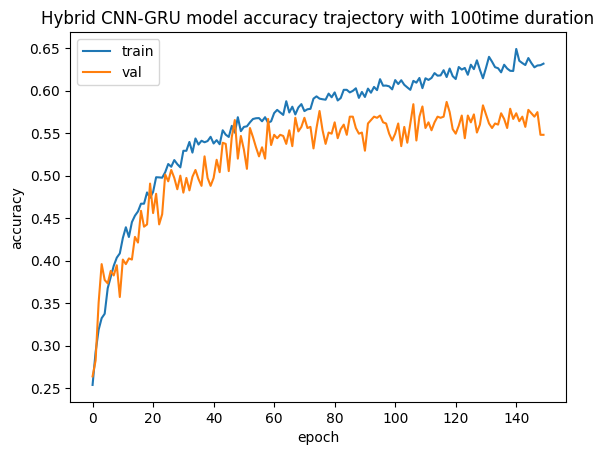

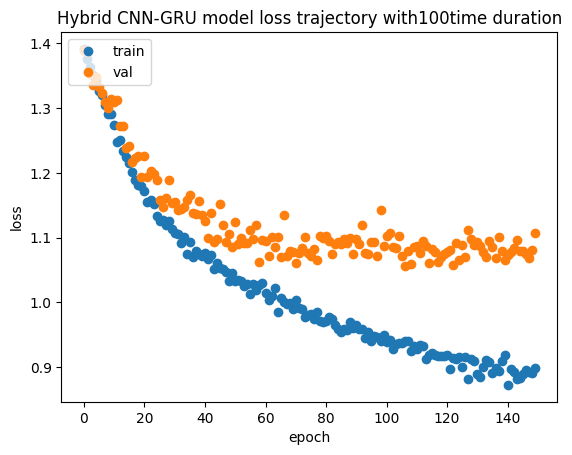

Test accuracy of the hybrid CNN-LSTM model: 0.5349887013435364
200
Epoch 1/150
88/88 [==============================] - 5s 44ms/step - loss: 1.3993 - accuracy: 0.2774 - val_loss: 1.3783 - val_accuracy: 0.2653
Epoch 2/150
88/88 [==============================] - 4s 41ms/step - loss: 1.3794 - accuracy: 0.2922 - val_loss: 1.3638 - val_accuracy: 0.2920
Epoch 3/150
88/88 [==============================] - 4s 41ms/step - loss: 1.3579 - accuracy: 0.3189 - val_loss: 1.3664 - val_accuracy: 0.3173
Epoch 4/150
88/88 [==============================] - 4s 42ms/step - loss: 1.3445 - accuracy: 0.3391 - val_loss: 1.3580 - val_accuracy: 0.3600
Epoch 5/150
88/88 [==============================] - 4s 42ms/step - loss: 1.3195 - accuracy: 0.3739 - val_loss: 1.3377 - val_accuracy: 0.3520
Epoch 6/150
88/88 [==============================] - 4s 43ms/step - loss: 1.2912 - accuracy: 0.3975 - val_loss: 1.3009 - val_accuracy: 0.3947
Epoch 7/150
88/88 [==============================] - 4s 43ms/step - loss: 1.2874 

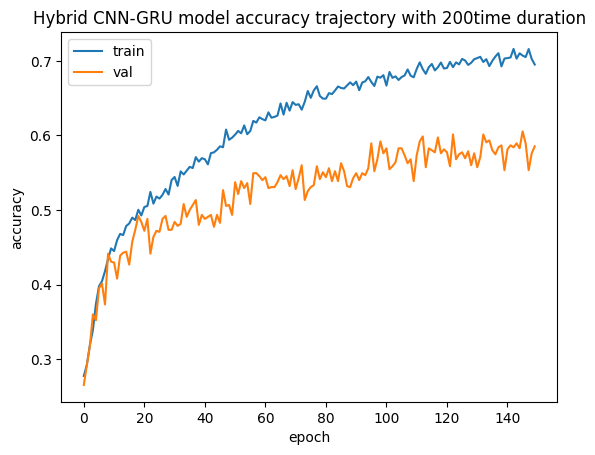

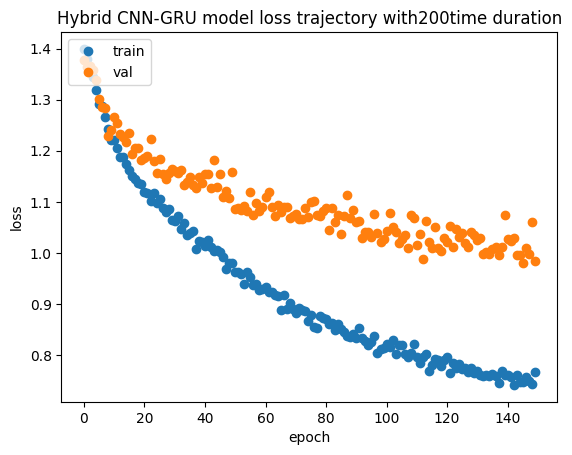

Test accuracy of the hybrid CNN-LSTM model: 0.6343114972114563
300
Epoch 1/150
88/88 [==============================] - 6s 50ms/step - loss: 1.3924 - accuracy: 0.2713 - val_loss: 1.3667 - val_accuracy: 0.3347
Epoch 2/150
88/88 [==============================] - 4s 48ms/step - loss: 1.3625 - accuracy: 0.3121 - val_loss: 1.3613 - val_accuracy: 0.2947
Epoch 3/150
88/88 [==============================] - 4s 49ms/step - loss: 1.3382 - accuracy: 0.3380 - val_loss: 1.3470 - val_accuracy: 0.3173
Epoch 4/150
88/88 [==============================] - 4s 49ms/step - loss: 1.3143 - accuracy: 0.3641 - val_loss: 1.3289 - val_accuracy: 0.3693
Epoch 5/150
88/88 [==============================] - 4s 49ms/step - loss: 1.2868 - accuracy: 0.3966 - val_loss: 1.2720 - val_accuracy: 0.3893
Epoch 6/150
88/88 [==============================] - 4s 48ms/step - loss: 1.2585 - accuracy: 0.4234 - val_loss: 1.2216 - val_accuracy: 0.4427
Epoch 7/150
88/88 [==============================] - 4s 49ms/step - loss: 1.2112 

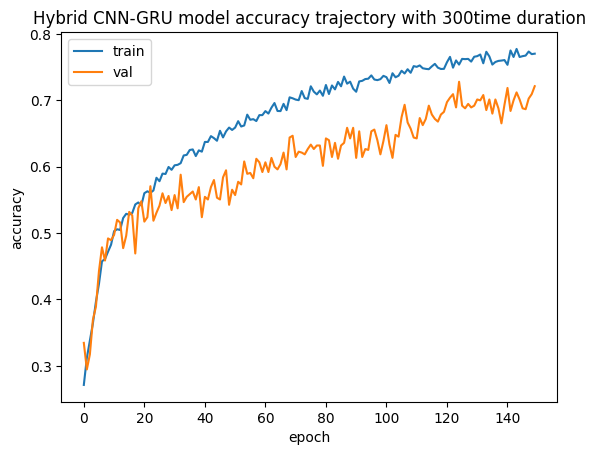

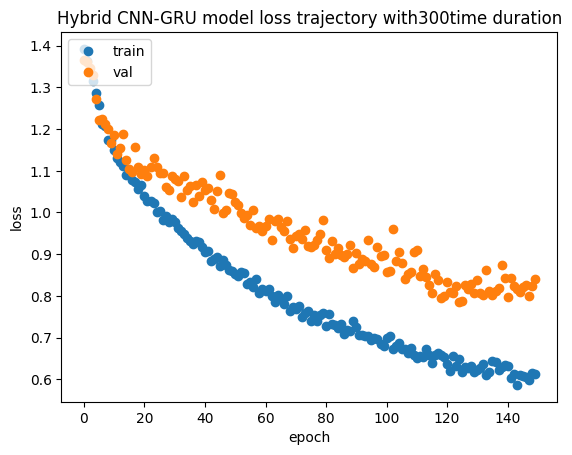

Test accuracy of the hybrid CNN-LSTM model: 0.6839728951454163
400
Epoch 1/150
88/88 [==============================] - 6s 58ms/step - loss: 1.3905 - accuracy: 0.2613 - val_loss: 1.3845 - val_accuracy: 0.2400
Epoch 2/150
88/88 [==============================] - 5s 54ms/step - loss: 1.3694 - accuracy: 0.2838 - val_loss: 1.3566 - val_accuracy: 0.3067
Epoch 3/150
88/88 [==============================] - 5s 55ms/step - loss: 1.3406 - accuracy: 0.3353 - val_loss: 1.3274 - val_accuracy: 0.3227
Epoch 4/150
88/88 [==============================] - 5s 56ms/step - loss: 1.3171 - accuracy: 0.3607 - val_loss: 1.3004 - val_accuracy: 0.3840
Epoch 5/150
88/88 [==============================] - 5s 56ms/step - loss: 1.2926 - accuracy: 0.3823 - val_loss: 1.2862 - val_accuracy: 0.4000
Epoch 6/150
88/88 [==============================] - 5s 55ms/step - loss: 1.2705 - accuracy: 0.4066 - val_loss: 1.2354 - val_accuracy: 0.4267
Epoch 7/150
88/88 [==============================] - 5s 54ms/step - loss: 1.2417 

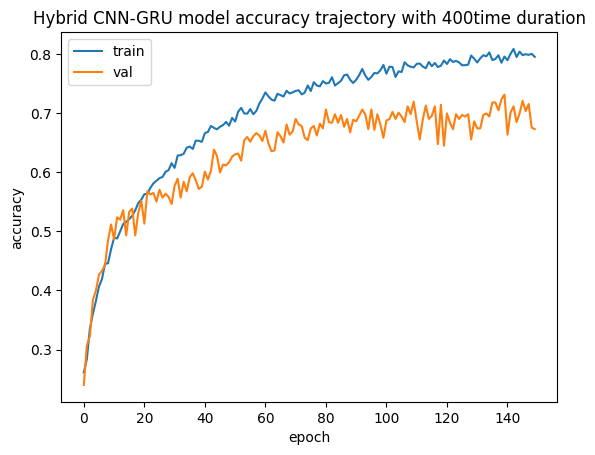

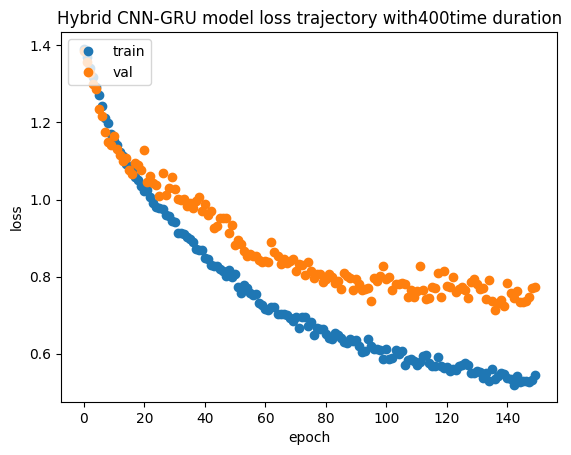

Test accuracy of the hybrid CNN-LSTM model: 0.6749435663223267
500
Epoch 1/150
88/88 [==============================] - 7s 67ms/step - loss: 1.3908 - accuracy: 0.2794 - val_loss: 1.3536 - val_accuracy: 0.3147
Epoch 2/150
88/88 [==============================] - 6s 67ms/step - loss: 1.3500 - accuracy: 0.3201 - val_loss: 1.3336 - val_accuracy: 0.3200
Epoch 3/150
88/88 [==============================] - 6s 66ms/step - loss: 1.3031 - accuracy: 0.3664 - val_loss: 1.2793 - val_accuracy: 0.3520
Epoch 4/150
88/88 [==============================] - 6s 65ms/step - loss: 1.2820 - accuracy: 0.3864 - val_loss: 1.2530 - val_accuracy: 0.3920
Epoch 5/150
88/88 [==============================] - 6s 65ms/step - loss: 1.2438 - accuracy: 0.4316 - val_loss: 1.2283 - val_accuracy: 0.4213
Epoch 6/150
88/88 [==============================] - 6s 65ms/step - loss: 1.2088 - accuracy: 0.4550 - val_loss: 1.2534 - val_accuracy: 0.3760
Epoch 7/150
88/88 [==============================] - 6s 65ms/step - loss: 1.1819 

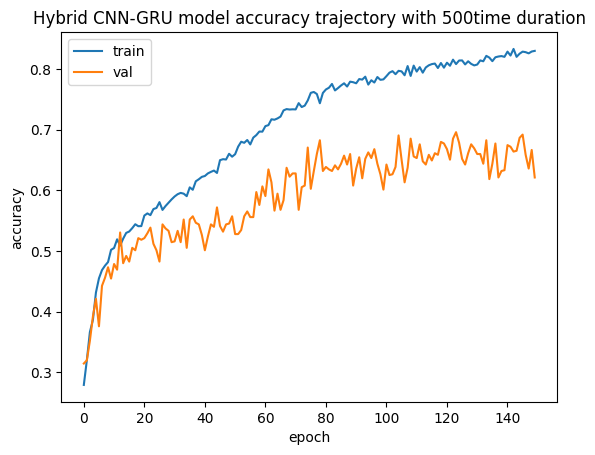

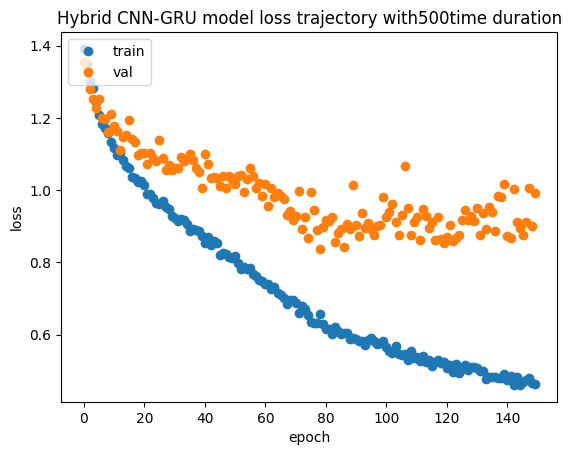

Test accuracy of the hybrid CNN-LSTM model: 0.6659142374992371
600
Epoch 1/150
88/88 [==============================] - 13s 123ms/step - loss: 1.3678 - accuracy: 0.3072 - val_loss: 1.3191 - val_accuracy: 0.3760
Epoch 2/150
88/88 [==============================] - 10s 117ms/step - loss: 1.3225 - accuracy: 0.3630 - val_loss: 1.2696 - val_accuracy: 0.3987
Epoch 3/150
88/88 [==============================] - 82s 936ms/step - loss: 1.2703 - accuracy: 0.4055 - val_loss: 1.2625 - val_accuracy: 0.4093
Epoch 4/150
88/88 [==============================] - 8s 86ms/step - loss: 1.2460 - accuracy: 0.4331 - val_loss: 1.2029 - val_accuracy: 0.4413
Epoch 5/150
88/88 [==============================] - 6s 70ms/step - loss: 1.1965 - accuracy: 0.4634 - val_loss: 1.2048 - val_accuracy: 0.4653
Epoch 6/150
88/88 [==============================] - 6s 71ms/step - loss: 1.1705 - accuracy: 0.4811 - val_loss: 1.2006 - val_accuracy: 0.4747
Epoch 7/150
88/88 [==============================] - 6s 70ms/step - loss: 1

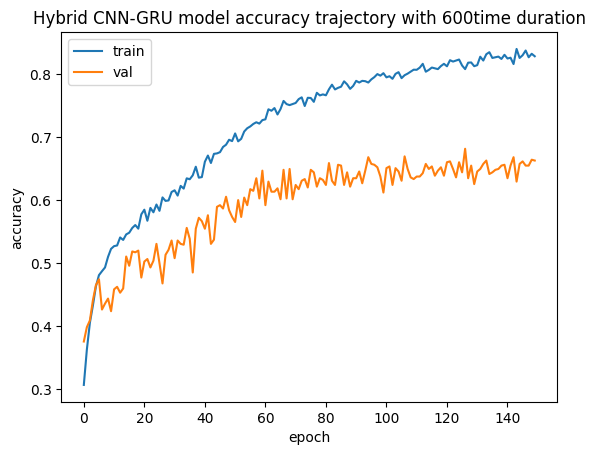

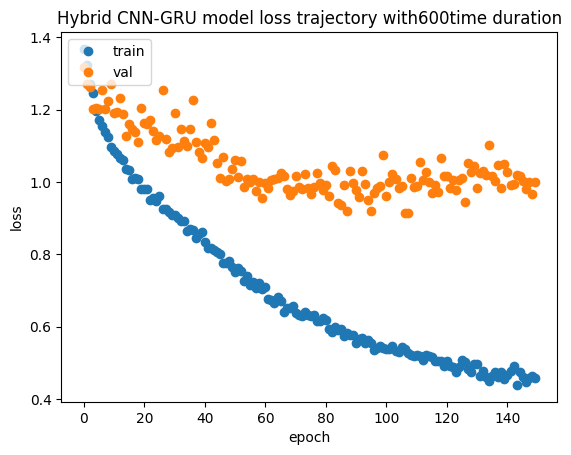

Test accuracy of the hybrid CNN-LSTM model: 0.6862302422523499
700
Epoch 1/150
88/88 [==============================] - 8s 76ms/step - loss: 1.3855 - accuracy: 0.2661 - val_loss: 1.3759 - val_accuracy: 0.2493
Epoch 2/150
88/88 [==============================] - 7s 76ms/step - loss: 1.3470 - accuracy: 0.3256 - val_loss: 1.3216 - val_accuracy: 0.3347
Epoch 3/150
88/88 [==============================] - 7s 76ms/step - loss: 1.2881 - accuracy: 0.3850 - val_loss: 1.2404 - val_accuracy: 0.3853
Epoch 4/150
88/88 [==============================] - 7s 77ms/step - loss: 1.2479 - accuracy: 0.4181 - val_loss: 1.2660 - val_accuracy: 0.3653
Epoch 5/150
88/88 [==============================] - 7s 77ms/step - loss: 1.2334 - accuracy: 0.4248 - val_loss: 1.1939 - val_accuracy: 0.4413
Epoch 6/150
88/88 [==============================] - 7s 76ms/step - loss: 1.1976 - accuracy: 0.4599 - val_loss: 1.1843 - val_accuracy: 0.4347
Epoch 7/150
88/88 [==============================] - 7s 79ms/step - loss: 1.1740 

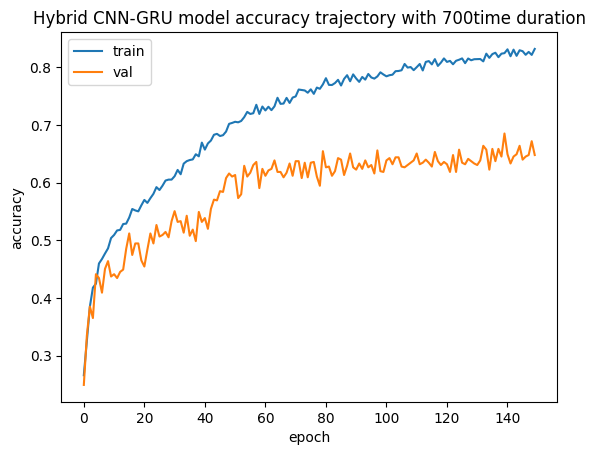

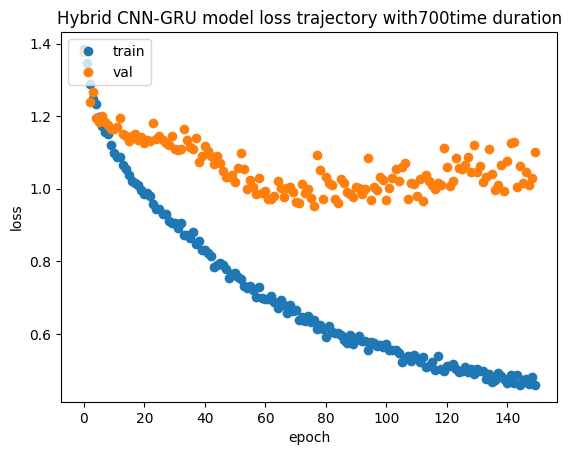

Test accuracy of the hybrid CNN-LSTM model: 0.6455981731414795
800
Epoch 1/150
88/88 [==============================] - 10s 100ms/step - loss: 1.3964 - accuracy: 0.2545 - val_loss: 1.3738 - val_accuracy: 0.3120
Epoch 2/150
88/88 [==============================] - 8s 92ms/step - loss: 1.3602 - accuracy: 0.3174 - val_loss: 1.3258 - val_accuracy: 0.3707
Epoch 3/150
88/88 [==============================] - 8s 93ms/step - loss: 1.3147 - accuracy: 0.3582 - val_loss: 1.3167 - val_accuracy: 0.3333
Epoch 4/150
88/88 [==============================] - 8s 89ms/step - loss: 1.2736 - accuracy: 0.4023 - val_loss: 1.2143 - val_accuracy: 0.4840
Epoch 5/150
88/88 [==============================] - 8s 90ms/step - loss: 1.2313 - accuracy: 0.4345 - val_loss: 1.1766 - val_accuracy: 0.4720
Epoch 6/150
88/88 [==============================] - 7s 85ms/step - loss: 1.2042 - accuracy: 0.4527 - val_loss: 1.1797 - val_accuracy: 0.4667
Epoch 7/150
88/88 [==============================] - 7s 84ms/step - loss: 1.184

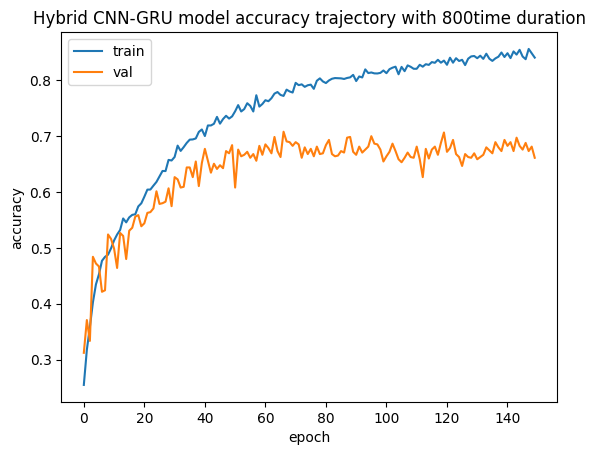

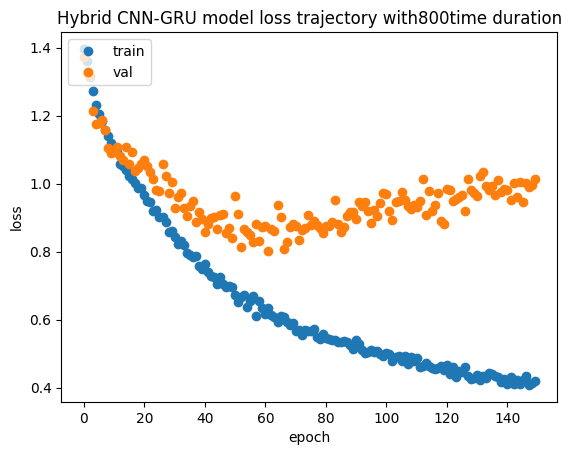

Test accuracy of the hybrid CNN-LSTM model: 0.6839728951454163
900
Epoch 1/150
88/88 [==============================] - 10s 96ms/step - loss: 1.4006 - accuracy: 0.2525 - val_loss: 1.3877 - val_accuracy: 0.2720
Epoch 2/150
88/88 [==============================] - 8s 96ms/step - loss: 1.3864 - accuracy: 0.2661 - val_loss: 1.3813 - val_accuracy: 0.2920
Epoch 3/150
88/88 [==============================] - 8s 93ms/step - loss: 1.3777 - accuracy: 0.2945 - val_loss: 1.3562 - val_accuracy: 0.3267
Epoch 4/150
88/88 [==============================] - 8s 94ms/step - loss: 1.3534 - accuracy: 0.3223 - val_loss: 1.3157 - val_accuracy: 0.3467
Epoch 5/150
88/88 [==============================] - 8s 94ms/step - loss: 1.3200 - accuracy: 0.3562 - val_loss: 1.2841 - val_accuracy: 0.3347
Epoch 6/150
88/88 [==============================] - 8s 95ms/step - loss: 1.2803 - accuracy: 0.3948 - val_loss: 1.2375 - val_accuracy: 0.3987
Epoch 7/150
88/88 [==============================] - 8s 92ms/step - loss: 1.2345

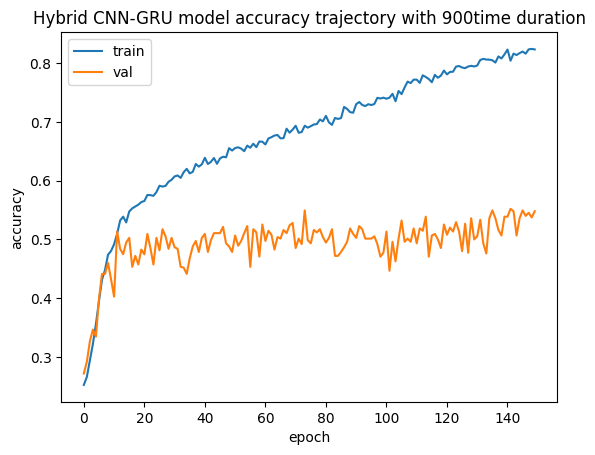

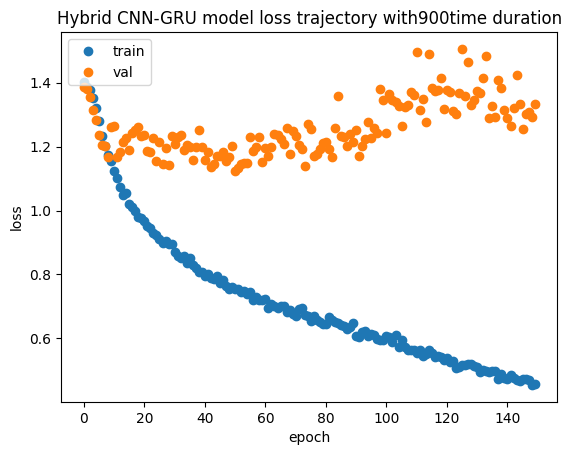

Test accuracy of the hybrid CNN-LSTM model: 0.5507900714874268
1000
Epoch 1/150
88/88 [==============================] - 10s 100ms/step - loss: 1.3952 - accuracy: 0.2592 - val_loss: 1.3805 - val_accuracy: 0.2733
Epoch 2/150
88/88 [==============================] - 9s 99ms/step - loss: 1.3657 - accuracy: 0.3169 - val_loss: 1.3556 - val_accuracy: 0.3240
Epoch 3/150
88/88 [==============================] - 9s 99ms/step - loss: 1.3253 - accuracy: 0.3591 - val_loss: 1.3559 - val_accuracy: 0.3200
Epoch 4/150
88/88 [==============================] - 9s 99ms/step - loss: 1.2734 - accuracy: 0.3970 - val_loss: 1.2255 - val_accuracy: 0.4480
Epoch 5/150
88/88 [==============================] - 9s 99ms/step - loss: 1.2440 - accuracy: 0.4111 - val_loss: 1.1971 - val_accuracy: 0.4653
Epoch 6/150
88/88 [==============================] - 9s 100ms/step - loss: 1.2152 - accuracy: 0.4534 - val_loss: 1.2069 - val_accuracy: 0.4413
Epoch 7/150
88/88 [==============================] - 10s 114ms/step - loss: 1

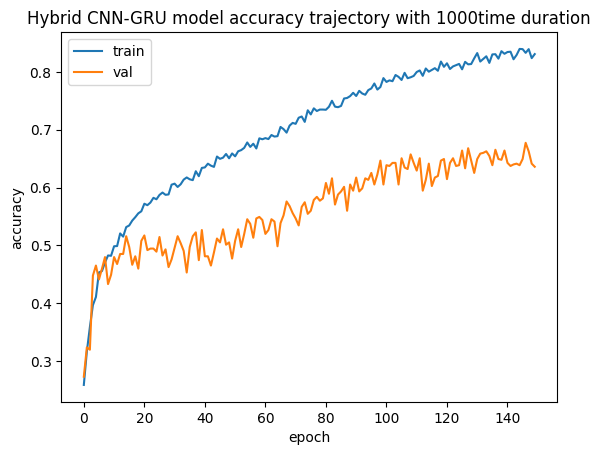

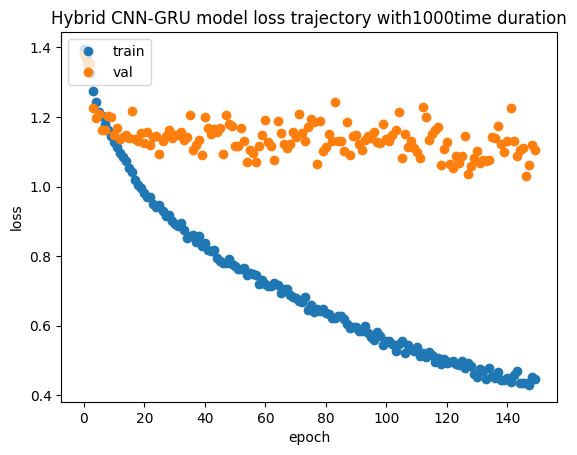

Test accuracy of the hybrid CNN-LSTM model: 0.6072234511375427


In [7]:
accuracy = []

for i in range(100, 1001, 100):
    print(i)
    x_train_trim = x_train[:, :i, :, :]
    x_valid_trim = x_valid[:, :i, :, :]
    x_test_trim = x_test[:, :i, :, :]

    hybrid_cnn_lstm_model = hybrid(i)
    # ADAM
    # Compiling the model
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_trim,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_trim, y_valid), verbose=True)

    # Plotting accuracy trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['accuracy'])
    plt.plot( hybrid_cnn_lstm_model_results.history['val_accuracy'])
    plt.title('Hybrid CNN-GRU model accuracy trajectory with ' + str(i) + 'time duration')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plotting loss trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['loss'],'o')
    plt.plot( hybrid_cnn_lstm_model_results.history['val_loss'],'o')
    plt.title('Hybrid CNN-GRU model loss trajectory with' + str(i) + 'time duration')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_trim, y_test, verbose=0)
    print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
    accuracy.append(hybrid_cnn_lstm_score[1])
    

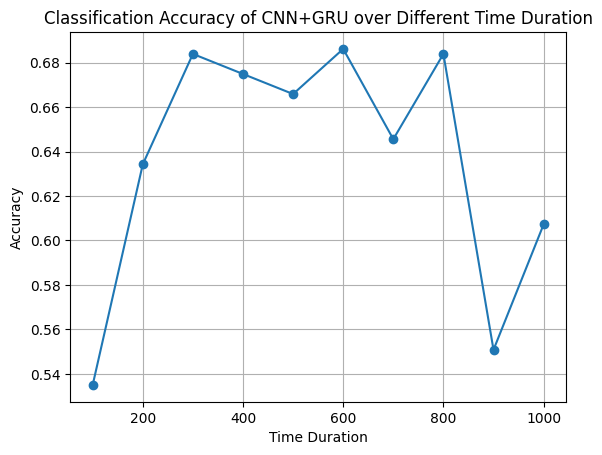

In [8]:
time_duration = list(range(100, 1001, 100))

# Plotting
plt.plot(time_duration, accuracy, marker='o')
plt.title('Classification Accuracy of CNN+GRU over Different Time Duration')
plt.xlabel('Time Duration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
